In [1]:
from dataloader import load_balanced_dataset
import backend.src.utils.utils as utils

In [2]:
data = load_balanced_dataset()
data = utils.clean_text(data, "text")

In [3]:
data

,sent_id,text,label
1170,001842-06-01,turnering peter gabriel ani difranco albumet u...,2
3900,001670-03-02,debutplata is this it fem gutane frå new york ...,2
7007,704974-08-06,kaizers utvider repertoaret kvitter trangeste ...,2
9558,400620-16-03,gamle helt xzibit plass,2
1801,003204-16-02,fryktelig vondt se sammenhengen,2
...,...,...,...
9076,300186-13-01,liksom nok,0
10219,000778-49-02,berøringsfeltet brukes spesielt godt lansering...,0
1586,301212-05-02,utgangspunktet opparbeidet viss skepsis knut e...,0
31,201911-23-01,imponert lydstyrken,0


In [4]:
from collections import Counter

num_words = Counter()
for review in data["text"]:
    for word in review.split(" "):
        num_words[word] += 1

num_words = len(num_words)
print("Number of words:", num_words)

Number of words: 15566


<AxesSubplot:>

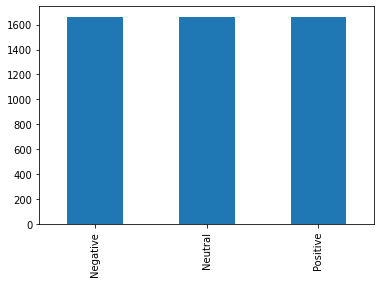

In [5]:
data["label"].replace({0: "Negative", 1: "Neutral", 2: "Positive"}).value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

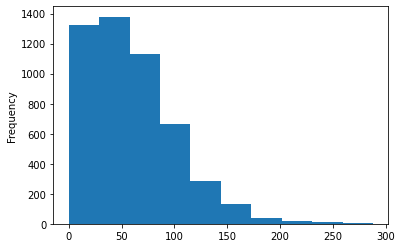

In [6]:
data["text"].str.len().plot.hist()

In [7]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences

X_train, X_test, y_train, y_test = train_test_split(data["text"], data["label"], test_size=0.1, random_state=42,
                                                    shuffle=True)

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [8]:
from random import randint

random_idx = randint(0, len(X_train))
review_label_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
review_label = review_label_mapping[int(y_train.iloc[random_idx])]

print(f"Review {random_idx} contains {len(X_train[random_idx])} words and is {review_label}")
print("Review content:", end="\n\n")
print(" ".join(tokenizer.index_word[idx] for idx in X_train[random_idx]))

Review 369 contains 14 words and is Negative
Review content:

unbroken gir kanskje mening terapeutisk verktøy filmfortelling sier selvhjelpsfilmer laget verdensberømte milliardærer begrenset nedslagsfelt


In [9]:
from collections import Counter

word_counter = Counter()
for review in X_train:
    for word in review:
        word_counter[tokenizer.index_word[word]] += 1

In [10]:
word_counter.most_common(10)

[('litt', 162),
 ('the', 136),
 ('får', 135),
 ('helt', 112),
 ('filmen', 111),
 ('to', 110),
 ('gjør', 108),
 ('godt', 107),
 ('år', 102),
 ('nok', 99)]

In [11]:
maxlen = 100

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [12]:
from keras.utils.np_utils import to_categorical
import numpy as np

y_train = np.array(y_train)
y_test = np.array(y_test)

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [13]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (4490, 100)
X_test shape: (499, 100)


In [14]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D

model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=128))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(units=128, dropout=0.2, return_sequences=True))
model.add(LSTM(units=128, dropout=0.2))
model.add(Dense(3, activation='softmax'))

In [15]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1992448   
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 128)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 2,256,003
Trainable params: 2,256,003
Non-trainable params: 0
______________________________________________

In [16]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=3)

epochs = 20
batch_size = 16
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1,
                    callbacks=[early_stop])

Epoch 1/20
225/225 [==============================] - 97s 407ms/step - loss: 1.0804 - accuracy: 0.3953 - val_loss: 1.0556 - val_accuracy: 0.4432
Epoch 2/20
225/225 [==============================] - 70s 310ms/step - loss: 0.7223 - accuracy: 0.6993 - val_loss: 1.0788 - val_accuracy: 0.5379
Epoch 3/20
225/225 [==============================] - 66s 293ms/step - loss: 0.2325 - accuracy: 0.9184 - val_loss: 1.4748 - val_accuracy: 0.5290
Epoch 4/20
225/225 [==============================] - 76s 340ms/step - loss: 0.0816 - accuracy: 0.9736 - val_loss: 1.6387 - val_accuracy: 0.5245
Epoch 5/20
225/225 [==============================] - 65s 288ms/step - loss: 0.0484 - accuracy: 0.9841 - val_loss: 1.8554 - val_accuracy: 0.5111


In [17]:
from datetime import datetime

model.save(f"models/SA-LSTM-MULTICLASS-BALANCED-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")

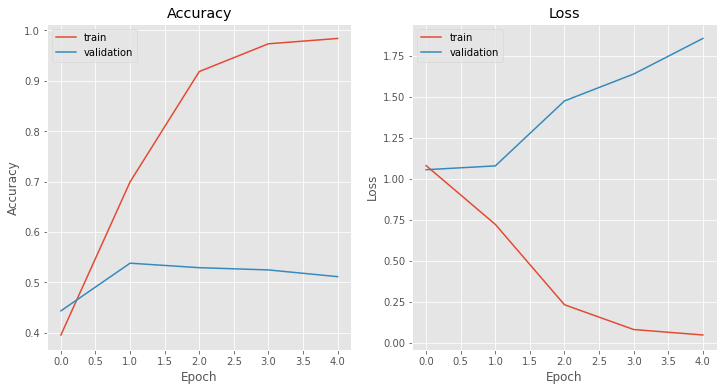

In [18]:
from backend.src.utils.utils import plot_history

plot_history(history)

In [19]:
# Evaluation
val_loss, val_acc = model.evaluate(X_test, y_test)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

16/16 [==============================] - 1s 68ms/step - loss: 1.9170 - accuracy: 0.5110
Validation loss: 1.91696298122406
Validation accuracy: 0.5110220313072205
